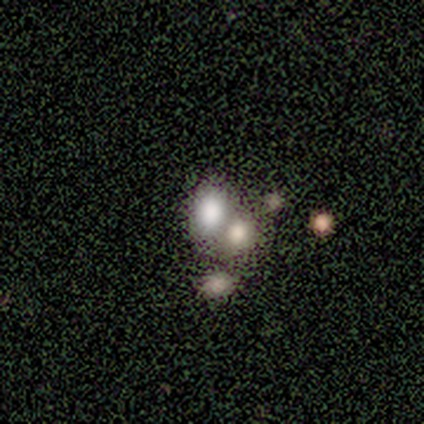

In [1]:
import logging
import pandas as pd
import os
from pytorch_lightning.plugins.training_type import DDPPlugin
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_galaxy_datasets.galaxy_datamodule import GalaxyDataModule
from zoobot.pytorch.training import losses
from zoobot.pytorch.estimators import define_model
from zoobot.pytorch.estimators import efficientnet_standard, resnet_torchvision_custom  # also resnet_detectron2_custom, imported below
import sys
sys.path.insert(0,'home/patrikas_v/to_zip/zoobot')
from zoobot.shared import label_metadata, schemas
from pytorch_lightning.loggers import WandbLogger
import torch
from pytorch_galaxy_datasets.prepared_datasets import (
    DecalsDR5Dataset,
    decals_dr5_setup,
    GZ2Dataset,
    gz2_setup
)
from pytorch_galaxy_datasets.galaxy_dataset import GalaxyDataset
from zoobot.pytorch.training import train_with_pytorch_lightning
from PIL import Image
from simplejpeg import decode_jpeg
import sys
from typing import Optional
import logging
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_galaxy_datasets import galaxy_dataset
sys.path.insert(0,'/home/patrikas_v/to_zip/AstroAugmentations')
import astroaugmentations as AA
from astroaugmentations.datasets.galaxy_mnist import GalaxyMNIST
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import simplejpeg
import torch
import os
import logging
import numpy as np
import pandas as pd


train_catalog, train_label_cols = decals_dr5_setup(
    root='/home/patrikas_v/to_zip/decals',  
    train=True,
    download=False
)
val_catalog, test_label_cols = decals_dr5_setup(
    root='/home/patrikas_v/to_zip/decals', 
    train=False,
    download=False
)

# adjusted_catalog = train_catalog.sample(1000)

galaxy = train_catalog.iloc[1]
def get_galaxy_label(galaxy, label_cols):
    # no longer casts to int64, user now responsible in df. If dtype is mixed, will try to infer with infer_objects
    return galaxy[label_cols].infer_objects().values.squeeze()  # squeeze for if there's one label_col
with open(galaxy['file_loc'], 'rb') as f:
    og_image = Image.fromarray(decode_jpeg(f.read()))
label = get_galaxy_label(galaxy,train_label_cols) #PIL!


og_image

In [2]:
galaxy

iauname                                             J115319.63+274642.4
upload_group                                            active_baseline
active_learning_on                                                False
in_gzd_ab                                                         False
png_loc                                dr5/J115/J115319.63+274642.4.png
                                            ...                        
relative_file_loc                      dr5/J115/J115319.63+274642.4.png
file_loc              /home/patrikas_v/to_zip/decals/images/J115/J11...
id_str                                              J115319.63+274642.4
filename                                        J115319.63+274642.4.jpg
subfolder                                                          J115
Name: 1, Length: 206, dtype: object

In [3]:
np.max(np.array(og_image))

233

In [4]:
train_catalog

,iauname,upload_group,active_learning_on,in_gzd_ab,png_loc,smooth-or-featured-dr5_total-votes,smooth-or-featured-dr5_smooth,smooth-or-featured-dr5_smooth_fraction,smooth-or-featured-dr5_featured-or-disk,smooth-or-featured-dr5_featured-or-disk_fraction,...,merging-dr12_neither_fraction,merging-dr12_tidal-debris_fraction,merging-dr12_both_fraction,merging-dr12_merger_fraction,dr_with_most_votes,relative_file_loc,file_loc,id_str,filename,subfolder
0,J143752.90+292250.0,active_priority,True,False,dr5/J143/J143752.90+292250.0.png,50,24.0,0.480000,22.0,0.440000,...,NaN,NaN,NaN,NaN,dr5,dr5/J143/J143752.90+292250.0.png,/home/patrikas_v/to_zip/decals/images/J143/J14...,J143752.90+292250.0,J143752.90+292250.0.jpg,J143
1,J115319.63+274642.4,active_baseline,False,False,dr5/J115/J115319.63+274642.4.png,5,4.0,0.800000,0.0,0.000000,...,NaN,NaN,NaN,NaN,dr5,dr5/J115/J115319.63+274642.4.png,/home/patrikas_v/to_zip/decals/images/J115/J11...,J115319.63+274642.4,J115319.63+274642.4.jpg,J115
2,J091304.01+132345.6,active_baseline,False,False,dr5/J091/J091304.01+132345.6.png,5,4.0,0.800000,0.0,0.000000,...,NaN,NaN,NaN,NaN,dr5,dr5/J091/J091304.01+132345.6.png,/home/patrikas_v/to_zip/decals/images/J091/J09...,J091304.01+132345.6,J091304.01+132345.6.jpg,J091
3,J153401.15+241918.5,active_baseline,False,False,dr5/J153/J153401.15+241918.5.png,8,5.0,0.625000,2.0,0.250000,...,NaN,NaN,NaN,NaN,dr5,dr5/J153/J153401.15+241918.5.png,/home/patrikas_v/to_zip/decals/images/J153/J15...,J153401.15+241918.5,J153401.15+241918.5.jpg,J153
4,J215331.36-082500.4,active_baseline,False,False,dr5/J215/J215331.36-082500.4.png,6,5.0,0.833333,1.0,0.166667,...,NaN,NaN,NaN,NaN,dr5,dr5/J215/J215331.36-082500.4.png,/home/patrikas_v/to_zip/decals/images/J215/J21...,J215331.36-082500.4,J215331.36-082500.4.jpg,J215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182442,J150401.99+311434.2,active_baseline,False,False,dr5/J150/J150401.99+311434.2.png,5,3.0,0.600000,2.0,0.400000,...,NaN,NaN,NaN,NaN,dr5,dr5/J150/J150401.99+311434.2.png,/home/patrikas_v/to_zip/decals/images/J150/J15...,J150401.99+311434.2,J150401.99+311434.2.jpg,J150
182443,J013534.12-014955.2,active_baseline,False,False,dr5/J013/J013534.12-014955.2.png,5,4.0,0.800000,0.0,0.000000,...,NaN,NaN,NaN,NaN,dr5,dr5/J013/J013534.12-014955.2.png,/home/patrikas_v/to_zip/decals/images/J013/J01...,J013534.12-014955.2,J013534.12-014955.2.jpg,J013
182444,J145818.35+091959.9,active_baseline,False,False,dr5/J145/J145818.35+091959.9.png,8,6.0,0.750000,2.0,0.250000,...,NaN,NaN,NaN,NaN,dr5,dr5/J145/J145818.35+091959.9.png,/home/patrikas_v/to_zip/decals/images/J145/J14...,J145818.35+091959.9,J145818.35+091959.9.jpg,J145
182445,J210708.21-074941.3,active_baseline,False,False,dr5/J210/J210708.21-074941.3.png,13,11.0,0.846154,1.0,0.076923,...,NaN,NaN,NaN,NaN,dr5,dr5/J210/J210708.21-074941.3.png,/home/patrikas_v/to_zip/decals/images/J210/J21...,J210708.21-074941.3,J210708.21-074941.3.jpg,J210


In [5]:
class ToGray():

    def __init__(self, reduce_channels=False):
        if reduce_channels:
            self.mean = lambda arr: arr.mean(axis=2, keepdims=True)
        else:
            self.mean = lambda arr: arr.mean(
                axis=2, keepdims=True).repeat(3, axis=2)

    def __call__(self, image, **kwargs):
        return self.mean(image)

class GrayscaleUnweighted(torch.nn.Module):

    def __init__(self, num_output_channels=1):
        super().__init__()
        self.num_output_channels = num_output_channels

    def forward(self, img):
        """
        PyTorch (and tensorflow) does greyscale conversion as a *weighted* mean by default (as colours have different perceptual brightnesses).
        Here, do a simple mean.
        Args:
            img (Tensor): Image to be converted to grayscale.

        Returns:
            Tensor: Grayscaled image.
        """
        # https://pytorch.org/docs/stable/generated/torch.mean.html
        return img.mean(dim=-3, keepdim=True)  # (..., C, H, W) convention

    def __repr__(self):
        return self.__class__.__name__ + '(num_output_channels={0})'.format(self.num_output_channels)

def default_torchvision_transforms(greyscale, resize_size, crop_scale_bounds, crop_ratio_bounds):
    # refactored out for use elsewhere, if need exactly these transforms
    # assume input is 0-255 uint8 tensor

    # automatically normalises from 0-255 int to 0-1 float
    transforms_to_apply = [transforms.ToTensor()]  # dataset gives PIL image currently

    if greyscale:
        # transforms.Grayscale() adds perceptual weighting to rgb channels
        transforms_to_apply += [GrayscaleUnweighted()]

    transforms_to_apply += [
        transforms.RandomResizedCrop(
            size=resize_size,  # assumed square
            scale=crop_scale_bounds,  # crop factor
            ratio=crop_ratio_bounds,  # crop aspect ratio
            interpolation=transforms.InterpolationMode.BILINEAR),  # new aspect ratio
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(
            degrees=180., interpolation=transforms.InterpolationMode.BILINEAR)
    ]
    
    return transforms_to_apply

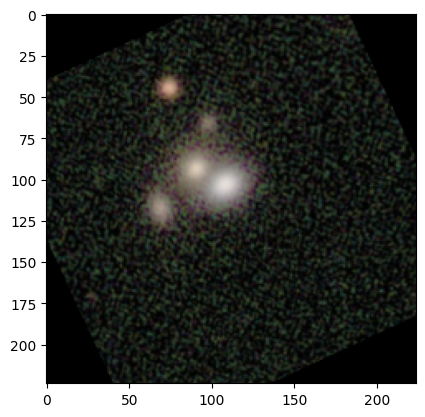

In [6]:
torchvision_transform = transforms.Compose(
    default_torchvision_transforms(
        greyscale=False,
        resize_size=224,
        crop_scale_bounds=(0.7, 0.8),
        crop_ratio_bounds=(0.9, 1.1),
    )
)

torchvision_img = torchvision_transform(og_image)

plt.imshow(torchvision_img.permute(1, 2, 0))

# plt.imshow(torchvision_img.numpy().reshape(224,224), cmap='Greys')


In [7]:
def transform_with_album(greyscale, resize_size, crop_scale_bounds, crop_ratio_bounds):
    if greyscale:
        transforms_to_apply = [A.Lambda(name='ToGray', image=ToGray(
            reduce_channels=True), always_apply=True)]
    else:
        transforms_to_apply = []

    transforms_to_apply += [
        A.ToFloat(max_value=255),
        # anything outside of the original image is set to 0.
        A.Rotate(limit=180, interpolation=1,
                    always_apply=True, border_mode=0, value=0),
        A.RandomResizedCrop(
            height=resize_size,  # after crop resize
            width=resize_size,
            scale=crop_scale_bounds,  # crop factor
            ratio=crop_ratio_bounds,  # crop aspect ratio
            interpolation=1,  # This is "INTER_LINEAR" == BILINEAR interpolation. See: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html
            always_apply=True
        ),  # new aspect ratio
        A.VerticalFlip(p=0.5),
        ToTensorV2()
    ]

    albumentations_transform = A.Compose(transforms_to_apply)
    return albumentations_transform

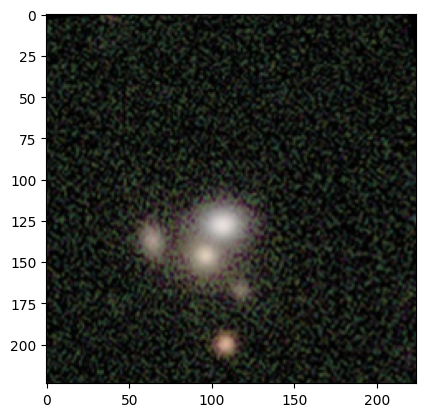

In [8]:
albumentations_transform = transform_with_album(
    greyscale=False,
    resize_size=224,
    crop_scale_bounds=(0.7, 0.8),
    crop_ratio_bounds=(0.9, 1.1),
)

albumentations_img = albumentations_transform(image = np.array(og_image))["image"]
plt.imshow(albumentations_img.permute(1, 2, 0))

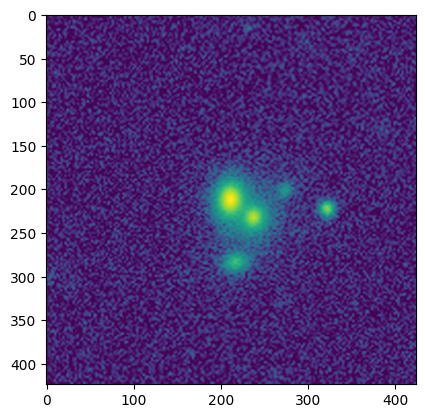

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [1, 1, 1])

test = (rgb2gray(np.array(og_image)))

plt.imshow(test)

In [10]:
def transform_with_astroaugmentations(greyscale):
    if greyscale:
        transforms_to_apply = [
            A.Lambda(
                name="ToGray", image=ToGray(reduce_channels=True), always_apply=True
            )
        ]
        # transforms_to_apply = [A.ToGray()]
    else:
        transforms_to_apply = []
        
    transforms_to_apply += (
        [
            A.ToFloat(max_value=255),
            A.Lambda(
                name="Adding Simulated Sources",
                image=AA.optical.SuperimposeSources(mode="sersic"),
                p=1,
            ),
            ToTensorV2(),
        ]
    )
    astroaugmentations_transform = A.Compose(transforms_to_apply)
    return astroaugmentations_transform

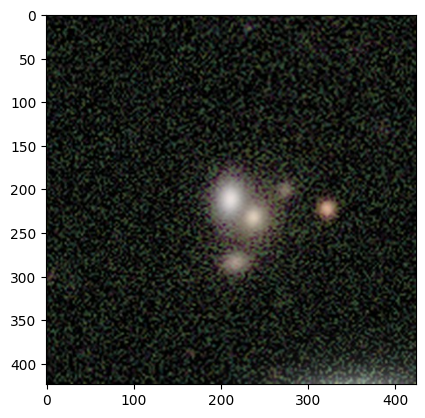

In [11]:
astroaugmentations_transform = transform_with_astroaugmentations(greyscale=0)

astroaugmentations_img = astroaugmentations_transform(image = np.array(og_image))["image"]

plt.imshow(astroaugmentations_img.permute(1, 2, 0))

In [12]:
from astroaugmentations.datasets.galaxy_mnist import GalaxyMNIST

a = GalaxyMNIST(root="./data", train=True, download=True)

# dir(GalaxyMNIST)

a

Dataset GalaxyMNIST
    Number of datapoints: 8000
    Root location: ./data
    Split: Train

In [2]:
sys.path.insert(0,'/home/patrikas_v/to_zip/AstroAugmentations/astroaugmentations/')
import image_domain as image_domain

template_transform = A.Compose([
    A.ToFloat(),
    A.ShiftScaleRotate(
        shift_limit=0.5,
        scale_limit=(0.8,1.2),
        rotate_limit=180,
        interpolation=1,
        border_mode=1,
        p=1
    ),
    A.VerticalFlip(p=0.5)
])

def transform_with_astroaugmentations(greyscale, CroppedTemplateOverlapDataset):
    if greyscale:
        transforms_to_apply = [
            A.Lambda(
                name="ToGray", image=ToGray(reduce_channels=True), always_apply=True
            )
        ]
        # transforms_to_apply = [A.ToGray()]
    else:
        transforms_to_apply = []
        
    transforms_to_apply += (
        [
            A.ToFloat(max_value=255),
                            A.Lambda(
                name='AddSersicSources',
                image=image_domain.optical.SuperimposeSources(
                    mode='sersic',
                    max_number=5,
                    extent=(5,80),
                    scaling='default'
                ),
                p=1
            ),
            A.Lambda(
                name='AddGaussianSources',
                image=image_domain.optical.SuperimposeSources(
                    mode='gaussian',
                    max_number=5,
                    extent=(3,20),
                    scaling=None
                ),
                p=1
            ),
            # Change properties of noise / imaging artefacts
            # A.Lambda(
            #     name='AddingRealData',
            #     image=image_domain.optical.CroppedTemplateOverlap(
            #         mode='dataset', dataset=CroppedTemplateOverlapDataset,
            #         template_transform=template_transform
            #     ),
            #     p=1
            # ),
            A.Lambda(
                name="Brightness perspective distortion",
                image=image_domain.BrightnessGradient(
                    limits=[0.5, 1]),
                p=1
            ),
            ToTensorV2(),
        ]
    )


    astroaugmentations_transform = A.Compose(transforms_to_apply)
    return astroaugmentations_transform

CroppedTemplateOverlapDataset = DecalsDR5Dataset(
    root='/home/patrikas_v/to_zip/decals',  
    train=True,
    download=False
)

# test_transform = transform_with_astroaugmentations(greyscale = 0, CroppedTemplateOverlapDataset = CroppedTemplateOverlapDataset)

# test = (test_transform(image = np.array(og_image))["image"].numpy())

In [14]:
plt.imshow(test.transpose(1, 2, 0))

ValueError: axes don't match array

In [ ]:
class ImgOptical(ComposedAugmentation):
    def __init__(self, dataset, p=0.5, tensor_out:bool=True, aug_no:int=None):
        super().__init__('optical', tensor_out=tensor_out)
        self.aug_no = aug_no
        template_transform = A.Compose([
            A.ToFloat(),
            A.ShiftScaleRotate(
                shift_limit=0.5,
                scale_limit=(0.8,1.2),
                rotate_limit=180,
                interpolation=1,
                border_mode=1,
                p=1
            ),
            A.VerticalFlip(p=0.5)
        ])
        if type(p)==list:
            self.p = p
        else:
            self.p = [p for i in range(10)]
        self.augmentations_list = [
            A.ToFloat(),
            # Slightly change source perspective
            A.ElasticTransform(
                alpha=1, sigma=100, alpha_affine=2, interpolation=1,
                border_mode=1, value=0,
                p=self.p[0]
            ),
            # Augment source confussion / overlap
            A.Lambda(
                name='AddSersicSources',
                image=image_domain.optical.SuperimposeSources(
                    mode='sersic',
                    max_number=5,
                    extent=(5,80),
                    scaling='default'
                ),
                p=self.p[1]
            ),
            A.Lambda(
                name='AddGaussianSources',
                image=image_domain.optical.SuperimposeSources(
                    mode='gaussian',
                    max_number=5,
                    extent=(3,20),
                    scaling=None
                ),
                p=self.p[2]
            ),
            # Change properties of noise / imaging artefacts
            A.Lambda(
                name='AddingRealData',
                image=image_domain.optical.CroppedTemplateOverlap(
                    mode='dataset', dataset=dataset,
                    template_transform=template_transform
                ),
                p=self.p[3]
            ),
            A.Lambda(
                name="Brightness perspective distortion",
                image=image_domain.BrightnessGradient(
                    limits=[0.5, 1]),
                p=self.p[4]
            ),
            # Model based transforms
            A.ShiftScaleRotate(
                shift_limit=0.1, scale_limit=0.1,
                rotate_limit=180, interpolation=2,
                border_mode=0,
            p=1),
            # Imaging artefacts
            A.Lambda(
                name="MissingData",
                image=image_domain.optical.ChannelWiseDropout(#
                    max_fraction=0.2,
                    min_width=10,
                    min_height=10,
                    max_holes=10,
                    channelwise_application=True
                ),
                p=self.p[6]
            )
        ]
        if self.aug_no is not None:
            self.augmentations_list = self.augmentations_list[:self.aug_no]
        self._tensor_check()
        self.augmentation = A.Compose(self.augmentations_list)

    def __call__(self, image, **kwargs):
        return self.augmentation(image=image)['image']

-0.016003420225560876

0.033333335 1.0


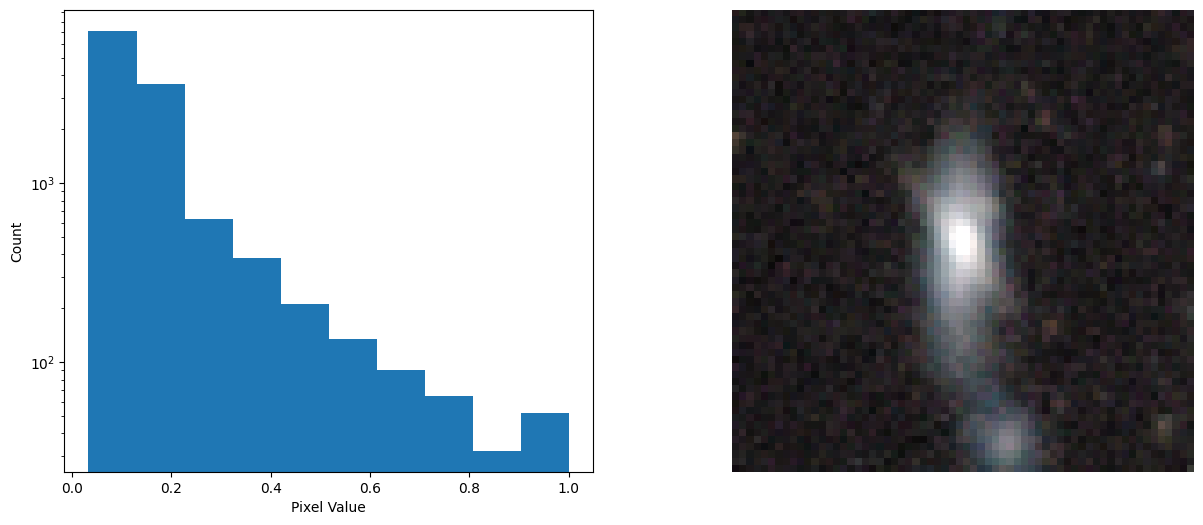

0.04117647 1.0


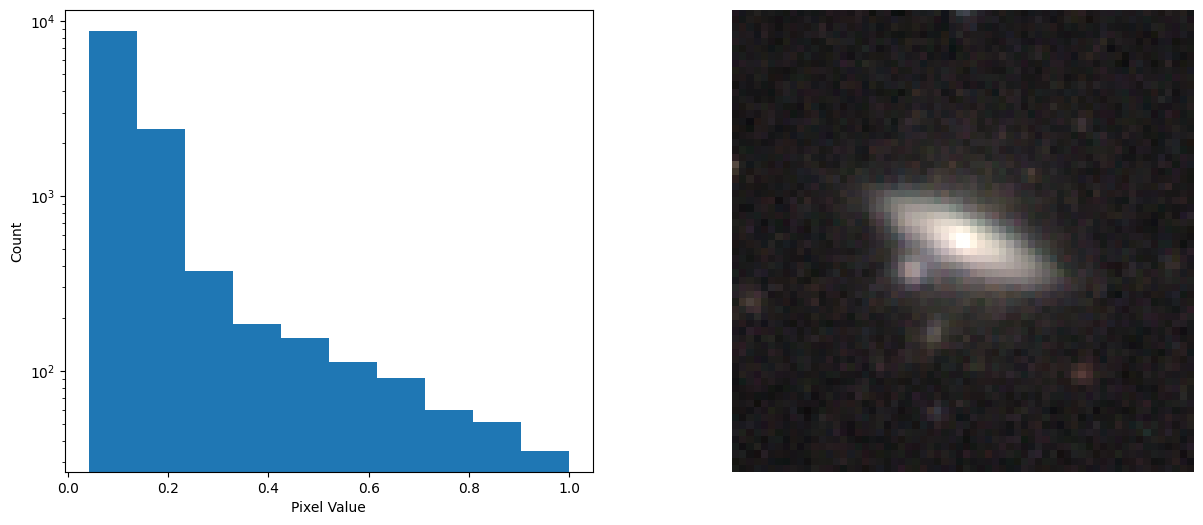

In [32]:
train_no_augmentation = GalaxyMNIST(root="/home/patrikas_v/to_zip/AstroAugmentations/data", train=True, download=True)
transform = A.Compose([
        A.Lambda(
            name='AddingRealData',
            image=image_domain.optical.CroppedTemplateOverlap(
                mode='dataset', dataset=train_no_augmentation,
                # template_transform=template_transform
            ),
            p=1
        )
])

train = GalaxyMNIST(root="/home/patrikas_v/to_zip/AstroAugmentations/data", train=True, download=True, transform=transform)

number_of_examples=2
for idx, (image, target) in enumerate(train):
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    image = np.asarray(image)
    print(image.min(), image.max())
    ax[0].hist(image.squeeze().flatten())
    ax[0].set_yscale('log')
    ax[0].set_xlabel("Pixel Value")
    ax[0].set_ylabel("Count")
    ax[1].imshow(image.squeeze(), cmap="Greys_r")
    ax[1].axis('off')
    plt.show()
    if idx>=number_of_examples-1:
        break


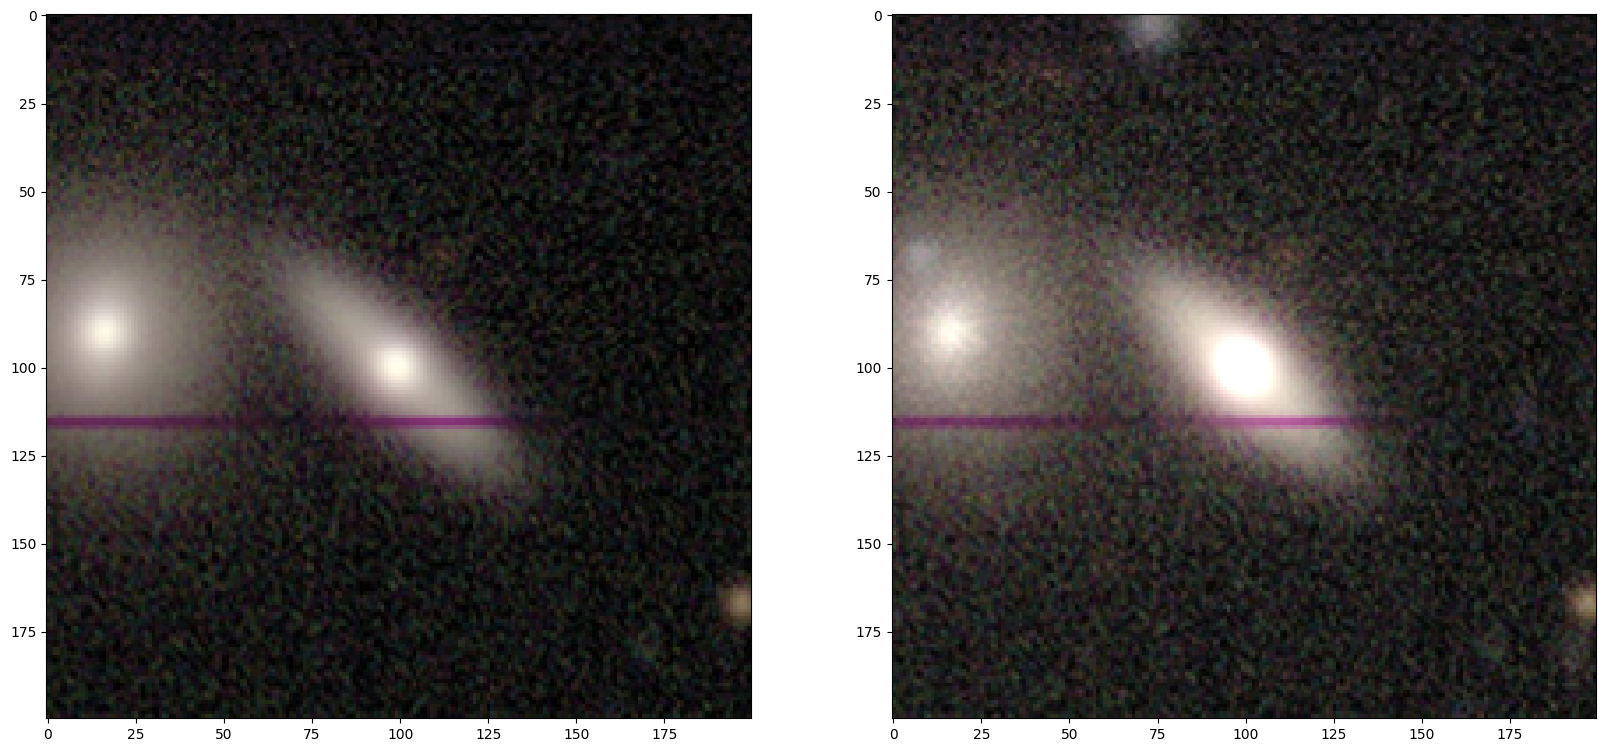

In [7]:
def plt_display_two(one, two):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    for ax, img in zip(axes, [one, two]):
            ax.imshow(img)

resize_size = 200

transform = A.Compose([
                A.Lambda(
            name='AddingRealData',
            image=image_domain.optical.CroppedTemplateOverlap(
                mode='catalog', catalog=train_catalog, resolution = resize_size,
                #template_transform=template_transform
            ),
            p=1
        )
])


galaxy = train_catalog.iloc[0]
with open (galaxy['file_loc'], 'rb') as f:
    datasample = decode_jpeg(f.read())
img = cv2.resize(datasample, (resize_size, resize_size))
test = transform(image=img)['image']
plt_display_two(img,test)